<a href="https://colab.research.google.com/github/adventuresinML/adventures-in-ml-code/blob/master/average_pooling_tensorflow2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!pip install -q tensorflow==2.0.0-alpha0

#### Install NGROK to provide a tunnel for TensorBoard utilization

In [0]:
!wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
!unzip ngrok-stable-linux-amd64.zip

--2019-05-17 22:12:02--  https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
Resolving bin.equinox.io (bin.equinox.io)... 52.72.145.109, 52.4.95.48, 52.45.111.123, ...
Connecting to bin.equinox.io (bin.equinox.io)|52.72.145.109|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 16529980 (16M) [application/octet-stream]
Saving to: ‘ngrok-stable-linux-amd64.zip.1’

ngrok-stable-linux- 100%[===================>]  15.76M  15.4MB/s    in 1.0s    

2019-05-17 22:12:03 (15.4 MB/s) - ‘ngrok-stable-linux-amd64.zip.1’ saved [16529980/16529980]

Archive:  ngrok-stable-linux-amd64.zip
replace ngrok? [y]es, [n]o, [A]ll, [N]one, [r]ename: n


In [0]:
LOG_DIR = './log'
get_ipython().system_raw(
    'tensorboard --logdir {} --host 0.0.0.0 --port 6006 &'
    .format(LOG_DIR)
)

In [0]:
import tensorflow as tf
from tensorflow.keras import layers
import tensorflow_datasets as tfds
import matplotlib.pylab as plt
import datetime as dt

In [0]:
split = (80, 10, 10)
splits = tfds.Split.TRAIN.subsplit(weighted=split)

(cat_train, cat_valid, cat_test), info = tfds.load('cats_vs_dogs', split=list(splits), with_info=True, as_supervised=True)

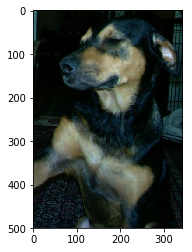

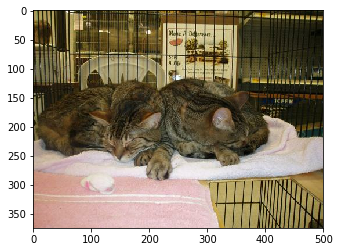

In [0]:
for image, label in cat_train.take(2):
  plt.figure()
  plt.imshow(image)

In [0]:
IMAGE_SIZE = 100
def pre_process_image(image, label):
  image = tf.cast(image, tf.float32)
  image = image / 255.0
  image = tf.image.resize(image, (IMAGE_SIZE, IMAGE_SIZE))
  return image, label

In [0]:
TRAIN_BATCH_SIZE = 64
cat_train = cat_train.map(pre_process_image).shuffle(1000).repeat().batch(TRAIN_BATCH_SIZE)
cat_valid = cat_valid.map(pre_process_image).repeat().batch(1000)

In [0]:
head = tf.keras.Sequential()
head.add(layers.Conv2D(32, (3, 3), input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3)))
head.add(layers.BatchNormalization())
head.add(layers.Activation('relu'))
head.add(layers.MaxPooling2D(pool_size=(2, 2)))

head.add(layers.Conv2D(32, (3, 3)))
head.add(layers.BatchNormalization())
head.add(layers.Activation('relu'))
head.add(layers.MaxPooling2D(pool_size=(2, 2)))

head.add(layers.Conv2D(64, (3, 3)))
head.add(layers.BatchNormalization())
head.add(layers.Activation('relu'))
head.add(layers.MaxPooling2D(pool_size=(2, 2)))

In [0]:
standard_classifier = tf.keras.Sequential()
standard_classifier.add(layers.Flatten())
standard_classifier.add(layers.BatchNormalization())
standard_classifier.add(layers.Dense(100))
standard_classifier.add(layers.Activation('relu'))
standard_classifier.add(layers.BatchNormalization())
standard_classifier.add(layers.Dense(100))
standard_classifier.add(layers.Activation('relu'))
standard_classifier.add(layers.Dense(1))
standard_classifier.add(layers.Activation('sigmoid'))

In [0]:
standard_classifier_with_do = tf.keras.Sequential()
standard_classifier_with_do.add(layers.Flatten())
standard_classifier_with_do.add(layers.BatchNormalization())
standard_classifier_with_do.add(layers.Dense(100))
standard_classifier_with_do.add(layers.Activation('relu'))
standard_classifier_with_do.add(layers.Dropout(0.5))
standard_classifier_with_do.add(layers.BatchNormalization())
standard_classifier_with_do.add(layers.Dense(100))
standard_classifier_with_do.add(layers.Activation('relu'))
standard_classifier_with_do.add(layers.Dense(1))
standard_classifier_with_do.add(layers.Activation('sigmoid'))

In [0]:
average_pool = tf.keras.Sequential()
average_pool.add(layers.AveragePooling2D())
average_pool.add(layers.Flatten())
average_pool.add(layers.Dense(1, activation='sigmoid'))

In [0]:
callbacks = [tf.keras.callbacks.TensorBoard(log_dir='./log/standard_classifier_with_do', update_freq='batch')]

#### Launch the NGROK tunnel for TensorBoard

In [37]:
get_ipython().system_raw('./ngrok http 6006 &')
! curl -s http://localhost:4040/api/tunnels | python3 -c \
    "import sys, json; print(json.load(sys.stdin)['tunnels'][0]['public_url'])"

https://f57a90a4.ngrok.io


In [0]:
pool_model = tf.keras.Sequential([
    head, 
    average_pool
])

In [0]:
pool_model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [23]:
pool_model.fit(cat_train, steps_per_epoch = 23262//TRAIN_BATCH_SIZE, epochs=7, 
               validation_data=cat_valid, validation_steps=10, callbacks=callbacks)

Epoch 1/7
363/363 [==============================] - 607s 2s/step - loss: 0.5183 - accuracy: 0.7363 - val_loss: 0.5808 - val_accuracy: 0.6749
Epoch 2/7
363/363 [==============================] - 595s 2s/step - loss: 0.4258 - accuracy: 0.8029 - val_loss: 0.5571 - val_accuracy: 0.7336
Epoch 3/7
363/363 [==============================] - 593s 2s/step - loss: 0.3745 - accuracy: 0.8333 - val_loss: 0.5120 - val_accuracy: 0.7631
Epoch 4/7
363/363 [==============================] - 594s 2s/step - loss: 0.3428 - accuracy: 0.8501 - val_loss: 0.3920 - val_accuracy: 0.8257
Epoch 5/7
363/363 [==============================] - 596s 2s/step - loss: 0.3116 - accuracy: 0.8665 - val_loss: 0.4942 - val_accuracy: 0.7919
Epoch 6/7
363/363 [==============================] - 595s 2s/step - loss: 0.2890 - accuracy: 0.8788 - val_loss: 0.3880 - val_accuracy: 0.8295
Epoch 7/7
363/363 [==============================] - 596s 2s/step - loss: 0.2640 - accuracy: 0.8905 - val_loss: 0.3437 - val_accuracy: 0.8533


In [0]:
standard_model = tf.keras.Sequential([
    head, 
    standard_classifier
])

In [0]:
standard_model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [0]:
standard_model.fit(cat_train, steps_per_epoch = 23262//TRAIN_BATCH_SIZE, epochs=10, validation_data=cat_valid, validation_steps=10, callbacks=callbacks)

Epoch 1/10
363/363 [==============================] - 527s 1s/step - loss: 0.5100 - accuracy: 0.7457 - val_loss: 0.6649 - val_accuracy: 0.6280
Epoch 2/10
363/363 [==============================] - 520s 1s/step - loss: 0.3549 - accuracy: 0.8428 - val_loss: 0.4466 - val_accuracy: 0.7830
Epoch 3/10
363/363 [==============================] - 519s 1s/step - loss: 0.2356 - accuracy: 0.9016 - val_loss: 0.4543 - val_accuracy: 0.8040
Epoch 4/10
363/363 [==============================] - 520s 1s/step - loss: 0.1505 - accuracy: 0.9409 - val_loss: 0.5076 - val_accuracy: 0.8060
Epoch 5/10
363/363 [==============================] - 516s 1s/step - loss: 0.0906 - accuracy: 0.9672 - val_loss: 0.5546 - val_accuracy: 0.8330
Epoch 6/10
363/363 [==============================] - 518s 1s/step - loss: 0.0615 - accuracy: 0.9772 - val_loss: 0.5067 - val_accuracy: 0.8590
Epoch 7/10
363/363 [==============================] - 520s 1s/step - loss: 0.0511 - accuracy: 0.9817 - val_loss: 0.7311 - val_accuracy: 0.8130

In [0]:
standard_model_with_do = tf.keras.Sequential([
    head, 
    standard_classifier_with_do
])

In [0]:
standard_model_with_do.compile(optimizer=tf.keras.optimizers.Adam(),
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [35]:
standard_model_with_do.fit(cat_train, steps_per_epoch = 23262//TRAIN_BATCH_SIZE, epochs=7, validation_data=cat_valid, validation_steps=10,
                           callbacks=callbacks)

Epoch 1/7
363/363 [==============================] - 623s 2s/step - loss: 0.5534 - accuracy: 0.7169 - val_loss: 0.7872 - val_accuracy: 0.5685
Epoch 2/7
363/363 [==============================] - 614s 2s/step - loss: 0.4390 - accuracy: 0.7987 - val_loss: 0.4364 - val_accuracy: 0.8026
Epoch 3/7
363/363 [==============================] - 618s 2s/step - loss: 0.3737 - accuracy: 0.8355 - val_loss: 0.4987 - val_accuracy: 0.7670
Epoch 4/7
363/363 [==============================] - 615s 2s/step - loss: 0.3292 - accuracy: 0.8545 - val_loss: 0.4552 - val_accuracy: 0.7900
Epoch 5/7
363/363 [==============================] - 620s 2s/step - loss: 0.2735 - accuracy: 0.8861 - val_loss: 0.3837 - val_accuracy: 0.8300
Epoch 6/7
363/363 [==============================] - 621s 2s/step - loss: 0.2317 - accuracy: 0.9035 - val_loss: 0.4269 - val_accuracy: 0.8380
Epoch 7/7
363/363 [==============================] - 621s 2s/step - loss: 0.1935 - accuracy: 0.9211 - val_loss: 0.4271 - val_accuracy: 0.8272


In [36]:
!zip -r ./file.zip './log'
from google.colab import files
files.download("./file.zip")

updating: log/ (stored 0%)
updating: log/standard_classifier/ (stored 0%)
updating: log/standard_classifier/plugins/ (stored 0%)
updating: log/standard_classifier/plugins/profile/ (stored 0%)
updating: log/standard_classifier/plugins/profile/2019-05-22_23-02-03/ (stored 0%)
updating: log/standard_classifier/plugins/profile/2019-05-22_23-02-03/local.trace (deflated 89%)
updating: log/standard_classifier/validation/ (stored 0%)
updating: log/standard_classifier/validation/events.out.tfevents.1558566167.1a1bd954c12a.135.75325.v2 (deflated 5%)
updating: log/standard_classifier/validation/events.out.tfevents.1558566115.1a1bd954c12a.135.74404.v2 (deflated 5%)
updating: log/standard_classifier/validation/events.out.tfevents.1558566101.1a1bd954c12a.135.71711.v2 (deflated 5%)
updating: log/standard_classifier/validation/events.out.tfevents.1558566202.1a1bd954c12a.135.79220.v2 (deflated 54%)
updating: log/standard_classifier/train/ (stored 0%)
updating: log/standard_classifier/train/events.out.t